In [19]:
import numpy as np
import pandas as pd
import warnings
import random
import h5py
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from torch.utils import data
from PIL import Image, ImageDraw
from typing import Tuple
from sklearn.metrics import roc_auc_score, classification_report
from torchvision import transforms
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [20]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
image_size = 96

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]) 
    ]),
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(device)

cuda


In [21]:
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    print("cuDNN auto-tuner is enabled")
else:
    torch.backends.cudnn.benchmark = False
    print("cuDNN auto-tuner is disabled")

cuDNN auto-tuner is enabled


In [22]:
class PCamDataset(Dataset):
    def __init__(self, path, transforms):
        self.path = path
        self.X = h5py.File(self.path +'_x.h5', 'r')['x']
        self.y = h5py.File(self.path +'_y.h5', 'r')['y']
        self.transforms = transforms

    def __getitem__(self, index):
        return (self.transforms(Image.fromarray(self.X[index,:,:,:])), self.y[index])

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

In [23]:
data_dir = "../input/patchcamelyon/"

train_dataset = PCamDataset(data_dir + "camelyonpatch_level_2_split_train", train_transforms)
valid_dataset  = PCamDataset(data_dir + "camelyonpatch_level_2_split_valid", test_transforms)
test_dataset  = PCamDataset(data_dir + "camelyonpatch_level_2_split_test", test_transforms)

print(len(train_dataset), len(valid_dataset), len(test_dataset))

262144 32768 32768


In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [25]:
class PCamCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.dropout = nn.Dropout(0.4)
        
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn4(self.conv4(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn5(self.conv5(x)))))
        x = self.avg(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [98]:
class PCamCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.dropout = nn.Dropout(0.4)
        
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.avg(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [115]:
class PCamCNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2)
        self.avg = nn.AvgPool2d(5)
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.avg(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

In [116]:
model_1 = PCamCNN1()
model_2 = PCamCNN2()
model_3 = PCamCNN3()

In [117]:
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)
optimizer_3 = optim.Adam(model_3.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()

In [62]:
print(f"Total number of CNN1 parameters = {sum(p.numel() for p in model_1.parameters() if p.requires_grad)}")
print(f"Total number of CNN2 parameters = {sum(p.numel() for p in model_2.parameters() if p.requires_grad)}")
print(f"Total number of CNN3 parameters = {sum(p.numel() for p in model_3.parameters() if p.requires_grad)}")

Total number of CNN1 parameters = 1571073
Total number of CNN2 parameters = 93825
Total number of CNN3 parameters = 660033


In [31]:
def train(model: torch.nn.Module, 
          model_name: str, 
          train_loader: torch.utils.data, 
          valid_loader: torch.utils.data,
          train_dataset: torch.utils.data.Dataset, 
          valid_dataset: torch.utils.data.Dataset,
          device: str, 
          optimizer: torch.optim, 
          criterion: torch.nn, 
          epochs: int) -> Tuple:
    train_loss_history = np.empty(0)
    train_accuracy_history = np.empty(0)
    valid_loss_history = np.empty(0)
    valid_accuracy_history = np.empty(0)
    best_roc_auc = 0
    best_accuracy = 0

    model = model.to(device)

    model.train()
    for epoch in range(epochs):
        preds_in_current_epoch = torch.empty(0, device=device)
        labels_in_current_epoch = torch.empty(0, device=device)
        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            preds_in_current_epoch = torch.cat((preds_in_current_epoch, torch.sigmoid(out)))
            labels_in_current_epoch = torch.cat((labels_in_current_epoch, target))

        labels_in_current_epoch = torch.squeeze(labels_in_current_epoch)
        total = len(labels_in_current_epoch)
        preds_in_current_epoch = torch.squeeze(preds_in_current_epoch)
        correct = ((preds_in_current_epoch > 0.5).float() == labels_in_current_epoch).sum().item()
        loss = criterion(preds_in_current_epoch, labels_in_current_epoch)
        accuracy = round(correct / total, 4)

        train_accuracy_history = np.append(train_accuracy_history, accuracy)
        train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())

        print(f"Train Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}")

        valid_labels = (torch.squeeze(torch.as_tensor(valid_dataset.y))).to(device)

        with torch.no_grad():
            predictions = torch.Tensor().float().to(device)

            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.to(device), target.to(device)
                target = torch.reshape(target, (8, 1)).float()
                out = model(data)
                predictions = torch.cat((predictions, torch.sigmoid(out)))

            total = valid_labels.shape[0]
            predictions = torch.squeeze(predictions)
            correct = ((predictions > 0.5).float() == valid_labels).sum().item()
            loss = criterion(predictions, valid_labels.float())
            accuracy = round(correct / total, 4)

            valid_accuracy_history = np.append(valid_accuracy_history, accuracy)
            valid_loss_history = np.append(valid_loss_history, loss.cpu().detach().numpy())

            print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")

            current_roc_auc = roc_auc_score(valid_labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
            print(f"ROC-AUC score = {current_roc_auc}")
            new_line = False
            if current_roc_auc > best_roc_auc:
                torch.save(model.state_dict(), "best_roc_auc_" + model_name + ".pth")
                print("Model saved successfully\n")
                best_roc_auc = current_roc_auc
                new_line = True
            if accuracy > best_accuracy:
                torch.save(model.state_dict(), "best_accuracy_" + model_name + ".pth")
                print("Model saved successfully\n")
                best_accuracy = accuracy
                new_line = True
            if not new_line:
                print()

    model.eval()
    torch.save(model.state_dict(), "final_checkpoint" + model_name + ".pth")
    
    return model, train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history, best_roc_auc

In [32]:
def show_loss_history(train_loss_history: np.array, 
                      valid_loss_history: np.array) -> None :
    train_loss_idx = list(range(0, len(train_loss_history)))
    valid_loss_idx = list(range(0, len(valid_loss_history)))

    plt.plot(train_loss_idx, train_loss_history, label="train_loss")
    plt.plot(valid_loss_idx, valid_loss_history, label="valid_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.title("Loss changing")

    plt.legend()
    plt.show()
    
def show_accuracy_history(train_accuracy_history: np.array, 
                          valid_accuracy_history: np.array) -> None:
    train_accuracy_idx = list(range(0, len(train_accuracy_history)))
    valid_accuracy_idx = list(range(0, len(valid_accuracy_history)))

    plt.plot(train_accuracy_idx, train_accuracy_history, label="train_accuracy")
    plt.plot(valid_accuracy_idx, valid_accuracy_history, label="valid_accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.title("Accuracy changing")

    plt.legend()
    plt.show()

def show_history(train_loss_history: np.array, 
                 valid_loss_history: np.array, 
                 train_accuracy_history: np.array, 
                 valid_accuracy_history: np.array):
    show_loss_history(train_loss_history, valid_loss_history)
    show_accuracy_history(train_accuracy_history, valid_accuracy_history)

In [48]:
def test(model: torch.nn.Module, 
         test_loader: torch.utils.data, 
         test_dataset: torch.utils.data.Dataset, 
         device: str, 
         threshold: float) -> np.array:
    classes = ['+', '-']
    test_labels = (torch.squeeze(torch.Tensor(test_dataset.y))).to(device)

    with torch.no_grad():
        predictions = torch.empty(0, device=device)

        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            out = model(data)
            loss = criterion(out, target)
            predictions = torch.cat((predictions, torch.sigmoid(out)))

        total = test_labels.shape[0]
        predictions = torch.squeeze(predictions)
        correct = ((predictions > 0.5).float() == test_labels).sum().item()
        loss = criterion(predictions, test_labels)
        accuracy = round(correct / total, 5)

        print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")

        binarized_predictions = predictions.cpu().detach().numpy()
        for i in range(len(predictions)):
            binarized_predictions[i] = 1.0 if binarized_predictions[i] > threshold else 0.0

        print(classification_report(test_labels.cpu().detach().numpy(), 
                                    binarized_predictions, 
                                    target_names=classes))
        print(f"ROC-AUC = {roc_auc_score(test_labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())}")
        
        return predictions

## CNN 1

In [34]:
train_config_1 = {
    "model": model_1,
    "model_name": "CNN1",
    "train_loader": train_loader, 
    "valid_loader": valid_loader, 
    "train_dataset": train_dataset, 
    "valid_dataset": valid_dataset,
    "device": device,
    "optimizer": optimizer_1,
    "criterion": criterion, 
    "epochs": 10
}

In [35]:
%%time
(model_1, 
 train_loss_history, 
 train_accuracy_history, 
 valid_loss_history, 
 valid_accuracy_history, 
 best_roc_auc) = train(**train_config_1)

  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 1, Loss: 0.6465652585029602, Accuracy: 0.7643
Valid Loss: 0.6651942729949951, Valid Accuracy: 0.744
ROC-AUC score = 0.8204186655364921
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 2, Loss: 0.6284205913543701, Accuracy: 0.7972
Valid Loss: 0.6335799098014832, Valid Accuracy: 0.7517
ROC-AUC score = 0.8391504261972229
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 3, Loss: 0.6212565898895264, Accuracy: 0.8101
Valid Loss: 0.6352530121803284, Valid Accuracy: 0.7896
ROC-AUC score = 0.8737500983989691
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 4, Loss: 0.6148970127105713, Accuracy: 0.8215
Valid Loss: 0.6252886652946472, Valid Accuracy: 0.7857
ROC-AUC score = 0.8676279493283056



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 5, Loss: 0.610427975654602, Accuracy: 0.8294
Valid Loss: 0.618033766746521, Valid Accuracy: 0.8054
ROC-AUC score = 0.8906508829312348
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 6, Loss: 0.6062476634979248, Accuracy: 0.8362
Valid Loss: 0.6351361870765686, Valid Accuracy: 0.795
ROC-AUC score = 0.8960432619219048
Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 7, Loss: 0.6031566858291626, Accuracy: 0.842
Valid Loss: 0.6112672090530396, Valid Accuracy: 0.8099
ROC-AUC score = 0.894920641024203
Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 8, Loss: 0.5997640490531921, Accuracy: 0.8477
Valid Loss: 0.6087114810943604, Valid Accuracy: 0.8302
ROC-AUC score = 0.9111500233737947
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 9, Loss: 0.597431480884552, Accuracy: 0.8516
Valid Loss: 0.6047044992446899, Valid Accuracy: 0.8227
ROC-AUC score = 0.9038852467171122



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 10, Loss: 0.594967246055603, Accuracy: 0.8552
Valid Loss: 0.6257811784744263, Valid Accuracy: 0.8117
ROC-AUC score = 0.9032345217755712

CPU times: user 3h 2min 34s, sys: 14min 47s, total: 3h 17min 21s
Wall time: 3h 25min 20s


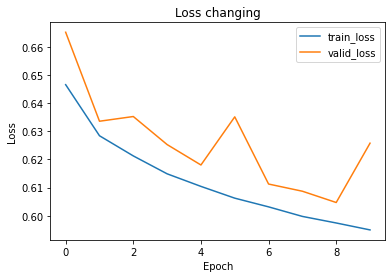

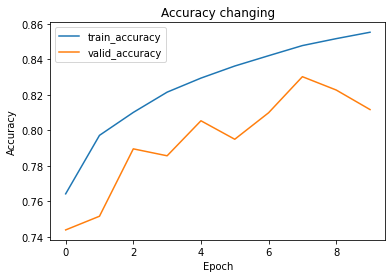

In [36]:
show_history(train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history)

In [49]:
%%time
predictions_of_cnn1 = test(model_1, test_loader, test_dataset, device, 0.5)

Test Loss: 0.5891386270523071
Test Accuracy: 0.86026
              precision    recall  f1-score   support

           +       0.81      0.94      0.87     16391
           -       0.93      0.78      0.85     16377

    accuracy                           0.86     32768
   macro avg       0.87      0.86      0.86     32768
weighted avg       0.87      0.86      0.86     32768

ROC-AUC = 0.9394639638577933
CPU times: user 36.3 s, sys: 282 ms, total: 36.6 s
Wall time: 37 s


In [127]:
roc_auc_checkpoint_model_1 = PCamCNN1().to(device)
roc_auc_checkpoint_model_1.load_state_dict(torch.load("best_roc_auc_CNN1.pth"))
roc_auc_checkpoint_predictions_of_cnn1 = test(roc_auc_checkpoint_model_1, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6127190589904785
Test Accuracy: 0.81729
              precision    recall  f1-score   support

           +       0.80      0.85      0.82     16391
           -       0.84      0.78      0.81     16377

    accuracy                           0.82     32768
   macro avg       0.82      0.82      0.82     32768
weighted avg       0.82      0.82      0.82     32768

ROC-AUC = 0.9019530217934327


In [126]:
accuracy_checkpoint_model_1 = PCamCNN1().to(device)
accuracy_checkpoint_model_1.load_state_dict(torch.load("best_accuracy_CNN1.pth"))
accuracy_checkpoint_predictions_of_cnn1 = test(accuracy_checkpoint_model_1, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6117141842842102
Test Accuracy: 0.8223
              precision    recall  f1-score   support

           +       0.80      0.86      0.83     16391
           -       0.85      0.79      0.82     16377

    accuracy                           0.82     32768
   macro avg       0.82      0.82      0.82     32768
weighted avg       0.82      0.82      0.82     32768

ROC-AUC = 0.9036012935506679


In [130]:
del model_1
del roc_auc_checkpoint_model_1
del accuracy_checkpoint_model_1
del train_loss_history
del train_accuracy_history 
del valid_loss_history
del valid_accuracy_history

NameError: name 'train_loss_history' is not defined

## CNN 2

In [106]:
train_config_2 = {
    "model": model_2,
    "model_name": "CNN2",
    "train_loader": train_loader, 
    "valid_loader": valid_loader, 
    "train_dataset": train_dataset, 
    "valid_dataset": valid_dataset,
    "device": device,
    "optimizer": optimizer_2,
    "criterion": criterion, 
    "epochs": 10
}

In [107]:
%%time
(model_2, 
 train_loss_history, 
 train_accuracy_history, 
 valid_loss_history, 
 valid_accuracy_history, 
 best_roc_auc) = train(**train_config_2)

  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 1, Loss: 0.6529731750488281, Accuracy: 0.7512
Valid Loss: 0.6503587961196899, Valid Accuracy: 0.7409
ROC-AUC score = 0.8188395527709251
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 2, Loss: 0.6358752250671387, Accuracy: 0.7848
Valid Loss: 0.6317633390426636, Valid Accuracy: 0.7872
ROC-AUC score = 0.8693660427159056
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 3, Loss: 0.630754828453064, Accuracy: 0.7936
Valid Loss: 0.6360766291618347, Valid Accuracy: 0.7808
ROC-AUC score = 0.8625695428928255



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 4, Loss: 0.6267247200012207, Accuracy: 0.8005
Valid Loss: 0.6302958130836487, Valid Accuracy: 0.795
ROC-AUC score = 0.8783186790410534
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 5, Loss: 0.6246281862258911, Accuracy: 0.8042
Valid Loss: 0.6235965490341187, Valid Accuracy: 0.7982
ROC-AUC score = 0.8846713921094806
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 6, Loss: 0.6224712133407593, Accuracy: 0.8074
Valid Loss: 0.627581775188446, Valid Accuracy: 0.7926
ROC-AUC score = 0.8766495408346753



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 7, Loss: 0.620578944683075, Accuracy: 0.8108
Valid Loss: 0.6141380071640015, Valid Accuracy: 0.8057
ROC-AUC score = 0.8953241424558016
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 8, Loss: 0.6184189319610596, Accuracy: 0.8156
Valid Loss: 0.6253371238708496, Valid Accuracy: 0.7985
ROC-AUC score = 0.8811044366974319



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 9, Loss: 0.6174572706222534, Accuracy: 0.8168
Valid Loss: 0.6193187236785889, Valid Accuracy: 0.8038
ROC-AUC score = 0.8886599222141598



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 10, Loss: 0.6161853075027466, Accuracy: 0.8191
Valid Loss: 0.6142752170562744, Valid Accuracy: 0.8161
ROC-AUC score = 0.9013939139009663
Model saved successfully

Model saved successfully

CPU times: user 2h 40min 20s, sys: 13min 48s, total: 2h 54min 9s
Wall time: 3h 1min 29s


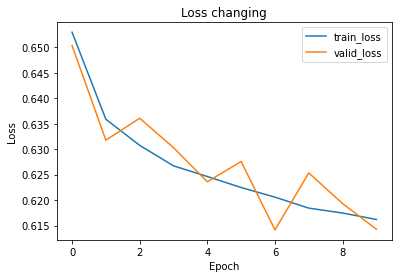

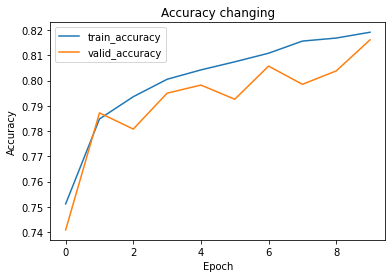

In [108]:
show_history(train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history)

In [109]:
%%time
predictions_of_cnn2 = test(model_2, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6269938945770264
Test Accuracy: 0.79196
              precision    recall  f1-score   support

           +       0.73      0.94      0.82     16391
           -       0.91      0.64      0.76     16377

    accuracy                           0.79     32768
   macro avg       0.82      0.79      0.79     32768
weighted avg       0.82      0.79      0.79     32768

ROC-AUC = 0.8921605487013864
CPU times: user 36.4 s, sys: 265 ms, total: 36.7 s
Wall time: 36.7 s


In [128]:
roc_auc_checkpoint_model_2 = PCamCNN2().to(device)
roc_auc_checkpoint_model_2.load_state_dict(torch.load("best_roc_auc_CNN2.pth"))
roc_auc_checkpoint_predictions_of_cnn2 = test(roc_auc_checkpoint_model_2, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6162847280502319
Test Accuracy: 0.80936
              precision    recall  f1-score   support

           +       0.78      0.86      0.82     16391
           -       0.84      0.76      0.80     16377

    accuracy                           0.81     32768
   macro avg       0.81      0.81      0.81     32768
weighted avg       0.81      0.81      0.81     32768

ROC-AUC = 0.8975693005356778


In [129]:
accuracy_checkpoint_model_2 = PCamCNN2().to(device)
accuracy_checkpoint_model_2.load_state_dict(torch.load("best_accuracy_CNN2.pth"))
accuracy_checkpoint_predictions_of_cnn2 = test(accuracy_checkpoint_model_2, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6168745756149292
Test Accuracy: 0.81079
              precision    recall  f1-score   support

           +       0.78      0.86      0.82     16391
           -       0.85      0.76      0.80     16377

    accuracy                           0.81     32768
   macro avg       0.81      0.81      0.81     32768
weighted avg       0.81      0.81      0.81     32768

ROC-AUC = 0.8960878826987232


In [ ]:
del model_2
del roc_auc_checkpoint_model_2
del accuracy_checkpoint_model_2
del train_loss_history
del train_accuracy_history 
del valid_loss_history
del valid_accuracy_history

## CNN 3

In [120]:
train_config_3 = {
    "model": model_3,
    "model_name": "CNN3",
    "train_loader": train_loader, 
    "valid_loader": valid_loader, 
    "train_dataset": train_dataset, 
    "valid_dataset": valid_dataset,
    "device": device,
    "optimizer": optimizer_3,
    "criterion": criterion, 
    "epochs": 10
}

In [121]:
%%time
(model_3, 
 train_loss_history, 
 train_accuracy_history, 
 valid_loss_history, 
 valid_accuracy_history, 
 best_roc_auc) = train(**train_config_3)

  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 1, Loss: 0.666645884513855, Accuracy: 0.7253
Valid Loss: 0.6699666976928711, Valid Accuracy: 0.7336
ROC-AUC score = 0.806102444876172
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 2, Loss: 0.652254581451416, Accuracy: 0.753
Valid Loss: 0.6647194623947144, Valid Accuracy: 0.7349
ROC-AUC score = 0.8114021720941689
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 3, Loss: 0.6476512551307678, Accuracy: 0.7626
Valid Loss: 0.6504298448562622, Valid Accuracy: 0.7474
ROC-AUC score = 0.829294147309598
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 4, Loss: 0.6450767517089844, Accuracy: 0.7674
Valid Loss: 0.6437265872955322, Valid Accuracy: 0.7507
ROC-AUC score = 0.8367197672350244
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 5, Loss: 0.6432766914367676, Accuracy: 0.7704
Valid Loss: 0.6452938914299011, Valid Accuracy: 0.7663
ROC-AUC score = 0.8461161344354236
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 6, Loss: 0.6417553424835205, Accuracy: 0.7741
Valid Loss: 0.6465685367584229, Valid Accuracy: 0.7632
ROC-AUC score = 0.8436096061474136



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 7, Loss: 0.640099287033081, Accuracy: 0.7769
Valid Loss: 0.671177864074707, Valid Accuracy: 0.718
ROC-AUC score = 0.8198411575118468



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 8, Loss: 0.638851523399353, Accuracy: 0.7781
Valid Loss: 0.6480817198753357, Valid Accuracy: 0.7673
ROC-AUC score = 0.8459979420510566
Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 9, Loss: 0.6375116109848022, Accuracy: 0.7804
Valid Loss: 0.6453133225440979, Valid Accuracy: 0.7714
ROC-AUC score = 0.8544816496162533
Model saved successfully

Model saved successfully



  0%|          | 0/32768 [00:00<?, ?it/s]

Train Epoch: 10, Loss: 0.6368329524993896, Accuracy: 0.782
Valid Loss: 0.6444256901741028, Valid Accuracy: 0.7763
ROC-AUC score = 0.8583580018227935
Model saved successfully

Model saved successfully

CPU times: user 2h 41min 5s, sys: 13min 52s, total: 2h 54min 57s
Wall time: 3h 2min 5s


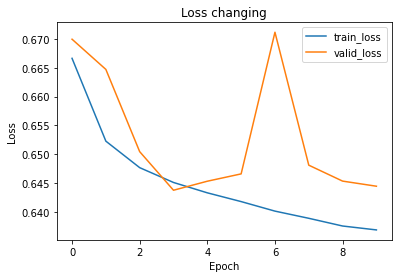

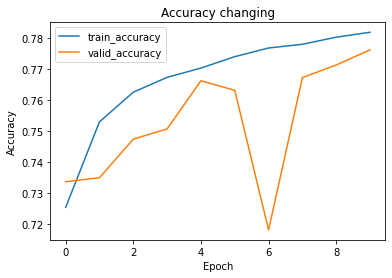

In [122]:
show_history(train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history)

In [123]:
%%time
predictions_of_cnn3 = test(model_3, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6386783123016357
Test Accuracy: 0.75076
              precision    recall  f1-score   support

           +       0.68      0.95      0.79     16391
           -       0.91      0.55      0.69     16377

    accuracy                           0.75     32768
   macro avg       0.80      0.75      0.74     32768
weighted avg       0.80      0.75      0.74     32768

ROC-AUC = 0.9004558366624117
CPU times: user 36.7 s, sys: 298 ms, total: 37 s
Wall time: 37.2 s


In [132]:
roc_auc_checkpoint_model_3 = PCamCNN3().to(device)
roc_auc_checkpoint_model_3.load_state_dict(torch.load("best_roc_auc_CNN3.pth"))
roc_auc_checkpoint_predictions_of_cnn3 = test(roc_auc_checkpoint_model_3, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6464006900787354
Test Accuracy: 0.77426
              precision    recall  f1-score   support

           +       0.77      0.77      0.77     16391
           -       0.77      0.77      0.77     16377

    accuracy                           0.77     32768
   macro avg       0.77      0.77      0.77     32768
weighted avg       0.77      0.77      0.77     32768

ROC-AUC = 0.8546358305109878


In [133]:
accuracy_checkpoint_model_3 = PCamCNN3().to(device)
accuracy_checkpoint_model_3.load_state_dict(torch.load("best_accuracy_CNN3.pth"))
accuracy_checkpoint_predictions_of_cnn3 = test(accuracy_checkpoint_model_3, test_loader, test_dataset, device, 0.5)

Test Loss: 0.6461426019668579
Test Accuracy: 0.77753
              precision    recall  f1-score   support

           +       0.78      0.78      0.78     16391
           -       0.78      0.78      0.78     16377

    accuracy                           0.78     32768
   macro avg       0.78      0.78      0.78     32768
weighted avg       0.78      0.78      0.78     32768

ROC-AUC = 0.8555724170917587


In [ ]:
del model_3
del roc_auc_checkpoint_model_3
del accuracy_checkpoint_model_3
del train_loss_history
del train_accuracy_history 
del valid_loss_history
del valid_accuracy_history

## Ensemble

In [135]:
final_predictions = 0.5*predictions_of_cnn1 + 0.3*roc_auc_checkpoint_predictions_of_cnn2 + 0.2*predictions_of_cnn3

In [140]:
final_predictions = final_predictions.cpu().detach().numpy()

In [152]:
labels = (torch.squeeze(torch.Tensor(test_dataset.y))).cpu().detach().numpy()

In [153]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import binarize

print(f"ROC-AUC = {roc_auc_score(labels, binarize(final_predictions.reshape(-1, 1), threshold=0.5))}\n"
      f"Accuracy = {accuracy_score(labels, binarize(final_predictions.reshape(-1, 1), threshold=0.5))}")

ROC-AUC = 0.8613547913967996
Accuracy = 0.86138916015625
